# ST580: PA1 Convolutional Neural Networks

In [13]:
import pathlib
import time

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

The following code block sets the random seed for PyTorch. This should ensure stable results if the notebook is run top-to-bottom, i.e., "Restart and Run All Cells." It will not guarantee reproducibility otherwise.

In [14]:
torch.manual_seed(0)

The following code block loads the MNIST feature and target data. One-hot-encoding is applied to the target data.

In [15]:

# Step 3: Update file paths to point to your Google Drive
import pathlib
import polars as pl
import pandas as pd

train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')
# Separate features and targets for training and test sets
train_features = train_df.iloc[:, 1:].values  # all columns except the first (label column)
train_targets = train_df.iloc[:, 0].values    # first column is the label
test_features = test_df.iloc[:, 1:].values
test_targets = test_df.iloc[:, 0].values




In [6]:
# Custom Dataset class
class MNISTDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Reshape each image to 28x28 pixels and convert to tensor
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('int64')  # Use int64 for labels in PyTorch
        return torch.tensor(image).unsqueeze(0), torch.tensor(label)  # Add channel dimension for CNN


The following code block:
- reloads the data,
- divides the feature data by 255 to convert all values to be in [0, 1],
- applies one-hot-encoding to the target data,
- splits the data into train, validation, and test datasets,
- and uses the custom `MNISTDataset` class to create PyTorch Dataset objects for each set.

The following code block defines the class for the PyTorch model.

In [16]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 5 * 5)  # Flatten the output
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

The following code block defines training parameters for our CNN implementation.

In [17]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001

The following code block creates the Dataloader objects we use to iterate through batches of the data.

In [18]:
# Create Dataset objects
train_dataset = MNISTDataset(train_features, train_targets)
test_dataset = MNISTDataset(test_features, test_targets)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

The following code block instantiates an instance of our CNN model.

In [19]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The following code block trains the model.

In [20]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Start the timer
start_time = time.time()

# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# End the timer and calculate total training time
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds.")

Epoch [1/10], Loss: 0.5471
Epoch [2/10], Loss: 0.3224
Epoch [3/10], Loss: 0.2782
Epoch [4/10], Loss: 0.2509
Epoch [5/10], Loss: 0.2336
Epoch [6/10], Loss: 0.2139
Epoch [7/10], Loss: 0.1993
Epoch [8/10], Loss: 0.1855
Epoch [9/10], Loss: 0.1708
Epoch [10/10], Loss: 0.1543
Training completed in 53.12 seconds.


In [21]:
# Evaluate the model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 90.42%


# Experimenting with Parameters

To try to find the best parameters, we will gridsearch the parameter space defined in the code below and try a full factorial of the options. This may inform the direction in which we should further tune the params.

In [22]:
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define experiment parameters
filter_sizes = [3, 5]  # Possible filter sizes
feature_maps = [(16, 32), (32, 64), (64, 128)]  # Number of output channels for each layer (half, original, double)
batch_sizes = [32, 64, 128]  # Possible batch sizes

# Results list to store all experiment results
results = []

class CustomCNN(nn.Module):
    def __init__(self, filter_size, feature_map1, feature_map2):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feature_map1, kernel_size=filter_size)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=feature_map1, out_channels=feature_map2, kernel_size=filter_size)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Calculate the flattened size based on a dummy forward pass
        self.flattened_size = self._calculate_flattened_size(28, filter_size, feature_map1, feature_map2)

        # Define fully connected layers using the calculated flattened size
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def _calculate_flattened_size(self, input_size, filter_size, feature_map1, feature_map2):
        # Create a dummy tensor with shape (1, 1, input_size, input_size)
        with torch.no_grad():
            x = torch.zeros(1, 1, input_size, input_size)
            x = self.conv1(x)
            x = self.pool1(self.relu1(x))
            x = self.conv2(x)
            x = self.pool2(self.relu2(x))
            # Flattened size is product of remaining dimensions
            return x.numel()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x



# Function to run each experiment
def run_experiment(filter_size, feature_map1, feature_map2, batch_size):
    # Create Dataset objects
    train_dataset = MNISTDataset(train_features, train_targets)
    test_dataset = MNISTDataset(test_features, test_targets)

    # Create DataLoaders with current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, loss function, and optimizer
    model = CustomCNN(filter_size, feature_map1, feature_map2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Start the timer
    start_time = time.time()

    # Training loop
    num_epochs = 3  # Use fewer epochs for testing purposes
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    # End the timer and calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    # Return the results
    return training_time, accuracy

# Run experiments for all combinations
for filter_size in filter_sizes:
    for feature_map1, feature_map2 in feature_maps:
        for batch_size in batch_sizes:
            print(f"Running experiment with Filter Size: {filter_size}, Feature Maps: ({feature_map1}, {feature_map2}), Batch Size: {batch_size}")
            training_time, accuracy = run_experiment(filter_size, feature_map1, feature_map2, batch_size)
            results.append({
                "Filter Size": filter_size,
                "Feature Map 1": feature_map1,
                "Feature Map 2": feature_map2,
                "Batch Size": batch_size,
                "Training Time (s)": training_time,
                "Accuracy (%)": accuracy
            })

# Create DataFrame from results
results_df = pd.DataFrame(results)
print("\nExperiment Results:")
print(results_df)


Running experiment with Filter Size: 3, Feature Maps: (16, 32), Batch Size: 32
Running experiment with Filter Size: 3, Feature Maps: (16, 32), Batch Size: 64
Running experiment with Filter Size: 3, Feature Maps: (16, 32), Batch Size: 128
Running experiment with Filter Size: 3, Feature Maps: (32, 64), Batch Size: 32
Running experiment with Filter Size: 3, Feature Maps: (32, 64), Batch Size: 64
Running experiment with Filter Size: 3, Feature Maps: (32, 64), Batch Size: 128
Running experiment with Filter Size: 3, Feature Maps: (64, 128), Batch Size: 32
Running experiment with Filter Size: 3, Feature Maps: (64, 128), Batch Size: 64
Running experiment with Filter Size: 3, Feature Maps: (64, 128), Batch Size: 128
Running experiment with Filter Size: 5, Feature Maps: (16, 32), Batch Size: 32
Running experiment with Filter Size: 5, Feature Maps: (16, 32), Batch Size: 64
Running experiment with Filter Size: 5, Feature Maps: (16, 32), Batch Size: 128
Running experiment with Filter Size: 5, Featu

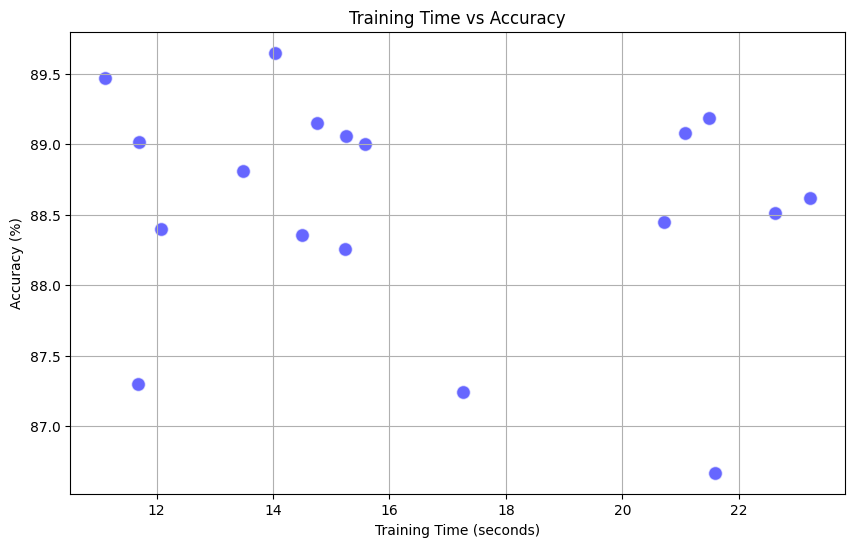

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(results_df["Training Time (s)"], results_df["Accuracy (%)"], c='blue', alpha=0.6, edgecolors='w', s=100)

# Annotate the plot with labels and title
plt.title("Training Time vs Accuracy")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Accuracy (%)")
plt.grid(True)

# Display the plot
plt.show()


This plot doesn't show that there is any discernible correlation by visual inspection between Training Time and Accuracy based on the parameters tested.


<ipython-input-24-09db9322c2c7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Filter Size", y="Accuracy (%)", data=results_df, palette="Blues")


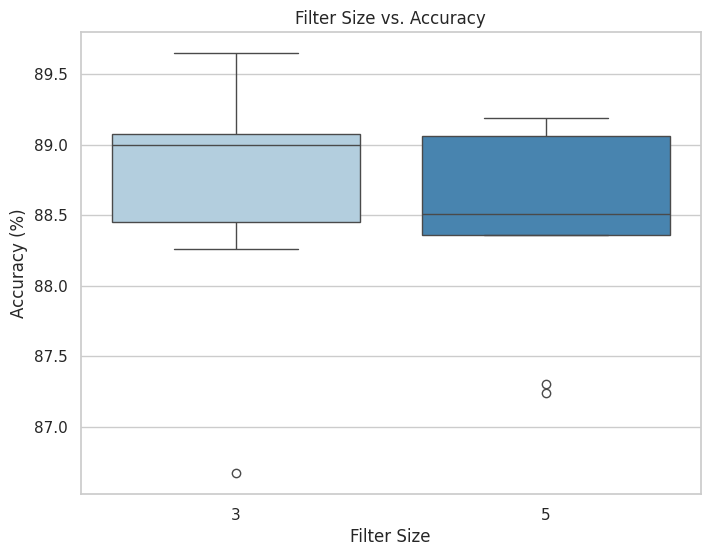

<ipython-input-24-09db9322c2c7>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Feature Map Combination", y="Accuracy (%)", data=results_df, palette="Greens")


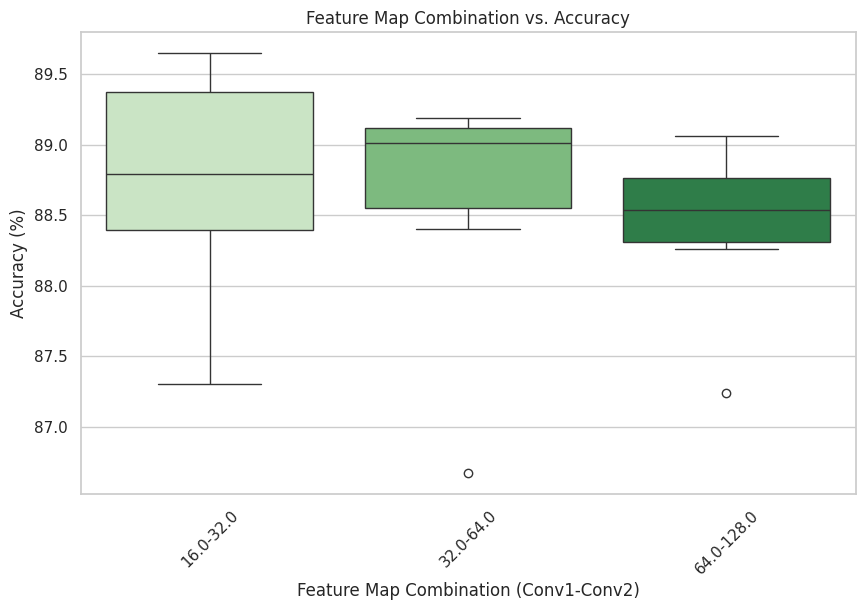

<ipython-input-24-09db9322c2c7>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Batch Size", y="Accuracy (%)", data=results_df, palette="Oranges")


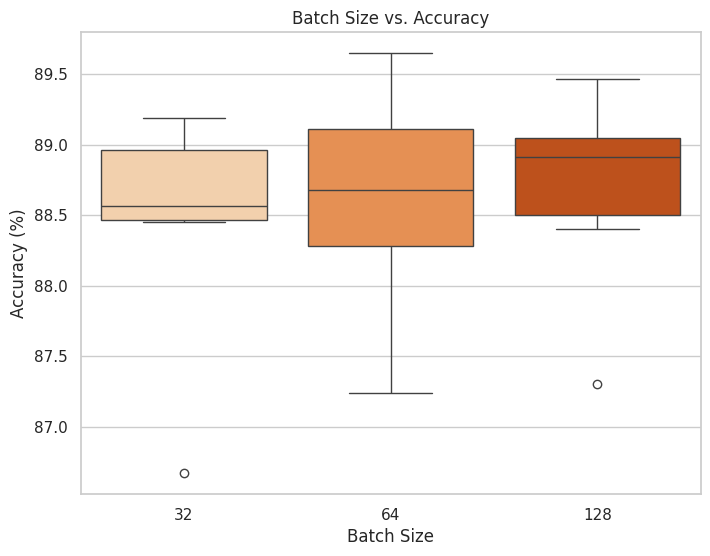

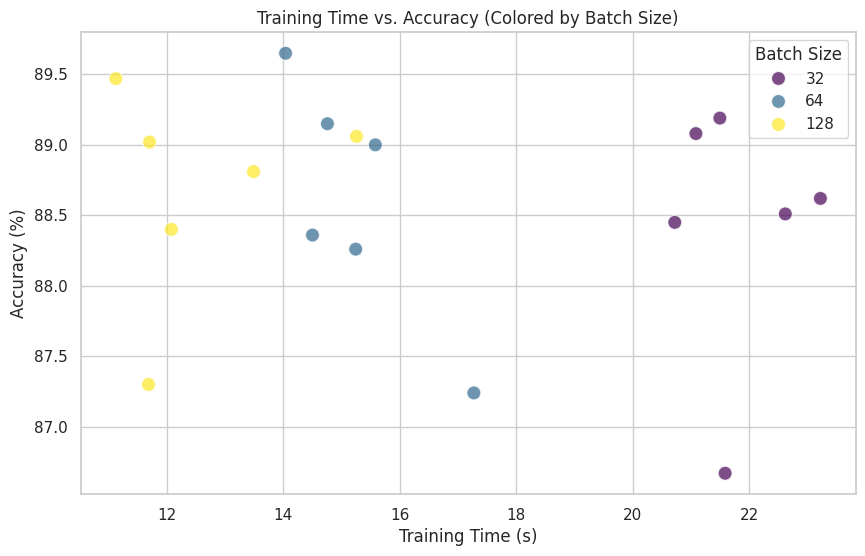

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plots
sns.set(style="whitegrid")

# 1. Filter Size vs. Accuracy
plt.figure(figsize=(8, 6))
sns.boxplot(x="Filter Size", y="Accuracy (%)", data=results_df, palette="Blues")
plt.title("Filter Size vs. Accuracy")
plt.xlabel("Filter Size")
plt.ylabel("Accuracy (%)")
plt.show()

# 2. Feature Maps vs. Accuracy
# We’ll combine both feature map values into a single categorical variable to simplify plotting.
results_df["Feature Map Combination"] = results_df.apply(lambda row: f"{row['Feature Map 1']}-{row['Feature Map 2']}", axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Feature Map Combination", y="Accuracy (%)", data=results_df, palette="Greens")
plt.title("Feature Map Combination vs. Accuracy")
plt.xlabel("Feature Map Combination (Conv1-Conv2)")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.show()

# 3. Batch Size vs. Accuracy
plt.figure(figsize=(8, 6))
sns.boxplot(x="Batch Size", y="Accuracy (%)", data=results_df, palette="Oranges")
plt.title("Batch Size vs. Accuracy")
plt.xlabel("Batch Size")
plt.ylabel("Accuracy (%)")
plt.show()

# 4. Training Time vs. Accuracy (with points colored by batch size)
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Training Time (s)", y="Accuracy (%)", hue="Batch Size", data=results_df, palette="viridis", s=100, edgecolor="w", alpha=0.7)
plt.title("Training Time vs. Accuracy (Colored by Batch Size)")
plt.xlabel("Training Time (s)")
plt.ylabel("Accuracy (%)")
plt.legend(title="Batch Size")
plt.grid(True)
plt.show()


An interestng observation is the distribution of the points by Batch Size when looking at it's effect on Accuracy(%) and Training Time (s). It initially seems like the data is uncorrelated, but when considering these groupings by the parameters, we see these patterns form which indicate the larger batch, 128, may improve training time with decreasing performance.

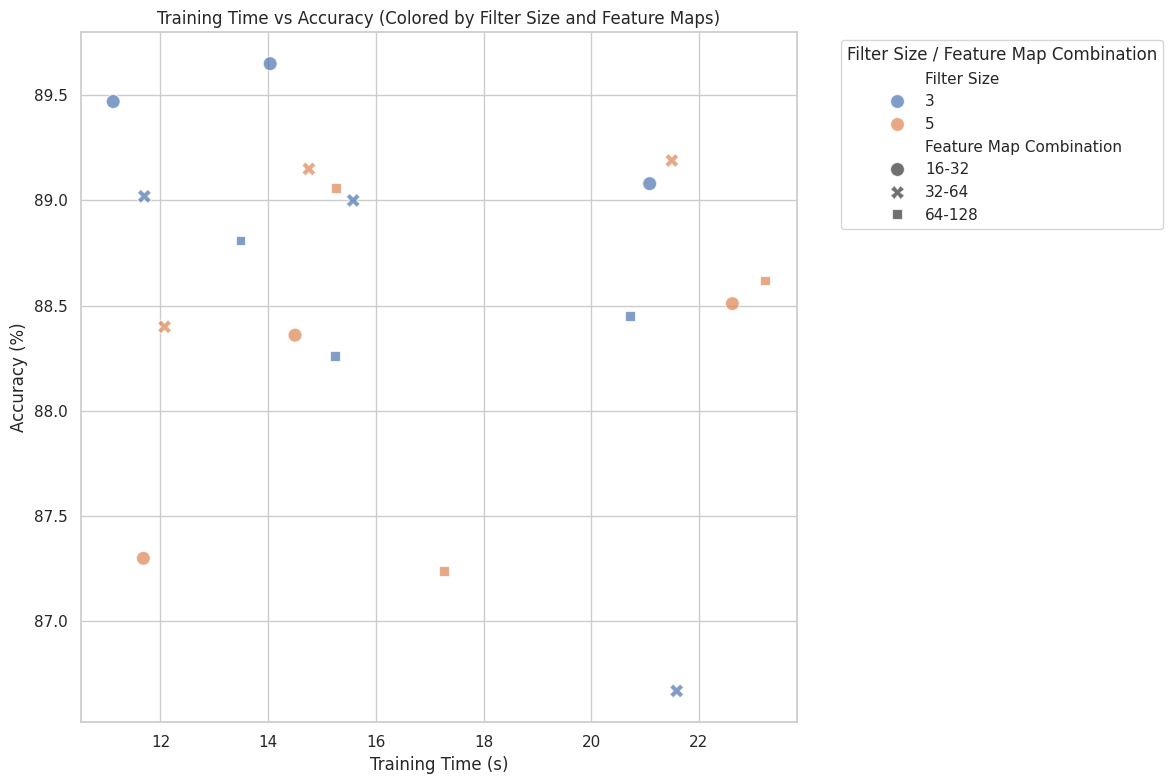

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, we need to ensure that the filter sizes and feature maps are categorical variables for coloring
results_df['Filter Size'] = results_df['Filter Size'].astype(str)
results_df['Feature Map Combination'] = results_df.apply(lambda row: f"{row['Feature Map 1']}-{row['Feature Map 2']}", axis=1)

# Create a scatter plot for Training Time vs Accuracy
plt.figure(figsize=(12, 8))
sns.scatterplot(data=results_df,
                x='Training Time (s)',
                y='Accuracy (%)',
                hue='Filter Size',
                style='Feature Map Combination',
                palette='deep',
                s=100,
                edgecolor='w',
                alpha=0.7)

# Customize plot
plt.title("Training Time vs Accuracy (Colored by Filter Size and Feature Maps)")
plt.xlabel("Training Time (s)")
plt.ylabel("Accuracy (%)")
plt.legend(title='Filter Size / Feature Map Combination', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


Again, when looking at the parameters, we can see that the blue circles (Filter Size:3, Map Combination:16-32) almost consistently perform the best, especially in the higher batch sizes that we have established train faster.

Next, I'd like to try an alternative experimentation method using the package "Optuna" which can more intelligently search the parameter space than the standard gridsearch.

In [28]:
import optuna
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


class CustomCNN(nn.Module):
    def __init__(self, filter_size, feature_map1, feature_map2):
        super(CustomCNN, self).__init__()
        self.filter_size = filter_size
        self.feature_map1 = feature_map1
        self.feature_map2 = feature_map2

        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.feature_map1, kernel_size=self.filter_size)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=self.feature_map1, out_channels=self.feature_map2, kernel_size=self.filter_size)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Calculate the size after convolutions and pooling
        self._to_linear = None
        self.convs(torch.randn(1, 1, 28, 28))  # Use a dummy tensor with correct input dimensions

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def convs(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        if self._to_linear is None:
            self._to_linear = x.numel()  # Calculate the total number of features after convolutions

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, self._to_linear)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x



# Objective function for Optuna
def objective(trial):
    filter_size = trial.suggest_categorical("filter_size", [3, 5])  # Filter sizes to explore
    feature_map1 = trial.suggest_int("feature_map1", 16, 64)  # Feature map sizes to explore
    feature_map2 = trial.suggest_int("feature_map2", 32, 128)  # Feature map sizes to explore
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])  # Batch sizes to explore

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = CustomCNN(filter_size, feature_map1, feature_map2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 10  # Adjust based on your needs
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Create a study object
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=20)  # You can increase the number of trials

# Print the best hyperparameters and their corresponding accuracy
print("Best Hyperparameters:", study.best_params)
print("Best Accuracy:", study.best_value)


[I 2024-11-05 19:11:04,947] A new study created in memory with name: no-name-0c162026-4b19-484b-936a-a4ded43e71b0
[I 2024-11-05 19:12:25,412] Trial 0 finished with value: 90.07 and parameters: {'filter_size': 5, 'feature_map1': 35, 'feature_map2': 72, 'batch_size': 32}. Best is trial 0 with value: 90.07.
[I 2024-11-05 19:13:35,901] Trial 1 finished with value: 89.71 and parameters: {'filter_size': 3, 'feature_map1': 22, 'feature_map2': 38, 'batch_size': 32}. Best is trial 0 with value: 90.07.
[I 2024-11-05 19:14:43,493] Trial 2 finished with value: 89.76 and parameters: {'filter_size': 3, 'feature_map1': 60, 'feature_map2': 49, 'batch_size': 32}. Best is trial 0 with value: 90.07.
[I 2024-11-05 19:15:26,415] Trial 3 finished with value: 89.41 and parameters: {'filter_size': 5, 'feature_map1': 52, 'feature_map2': 75, 'batch_size': 128}. Best is trial 0 with value: 90.07.
[I 2024-11-05 19:16:08,374] Trial 4 finished with value: 88.86 and parameters: {'filter_size': 5, 'feature_map1': 54,

Best Hyperparameters: {'filter_size': 3, 'feature_map1': 42, 'feature_map2': 81, 'batch_size': 64}
Best Accuracy: 90.75


This is relatively consistent with the observations we had made earlier, small filter, while batch size is relatively irrelevant. I believe a good next step would be to begin changing the architecture, adding or removing various types of layers, or even using transfer learning such as ResNet50.

**Acknowledgement**: This document was generated with the assistance of AI-based language modeling (via ChatGPT, OpenAI).